In [1]:
import os
os.chdir("..")

In [2]:
import time
import pandas as pd
from lightning_lite.utilities.seed import seed_everything
from shell_data.dataset.dataset import get_train_val_test_subsets
import torch
import os
from shell_data.utils.config import (
    ShELLDataSharingConfig,
    DatasetConfig,
    TaskModelConfig,
    TrainingConfig,
    ExperienceReplayConfig,
    DataValuationConfig,
    RouterConfig,
    BoltzmanExplorationConfig,
)
from shell_data.utils.record import Record, snapshot_perf, snapshot_conf_mat
import numpy as np
from shell_data.shell_agent.shell_agent_classification import ShELLClassificationAgent
from itertools import combinations
import umap
from copy import deepcopy


import matplotlib.pyplot as plt
# import mplcyberpunk
# plt.style.use("cyberpunk")
# plt.style.use('bmh')
import seaborn as sns
plt.style.use("fivethirtyeight")
# plt.style.use("xkcd")
sns.set_style("whitegrid")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import random
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
torch.use_deterministic_algorithms(True)
seed_everything(0)

2023-02-05 16:57:56.760887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 16:57:57.321916: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-05 16:57:57.321964: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-05 16:57:57.321968: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

0

In [3]:
# calculate the per-class accuracy from the confusion matrix
def per_class_acc(conf_mat):
    return np.diag(conf_mat) / conf_mat.sum(axis=1)

def per_class_true_labels(conf_mat):
    return conf_mat.sum(axis=1)

def acc(conf_mat):
    # total accuracy
    return np.diag(conf_mat).sum() / conf_mat.sum()

def predicted_cls_freq(conf_mat):
    # frequency that a class is predicted
    return conf_mat.sum(axis=0) / conf_mat.sum()


def to_features(X):
    return X.view(X.size(0), -1)

In [4]:
def load_snapshot_conf_mats(record_name, ll_time):
    train_conf = np.load(f"{record_name}_train_conf_mat_{ll_time}.npy")
    test_conf = np.load(f"{record_name}_test_conf_mat_{ll_time}.npy")
    val_conf = np.load(f"{record_name}_val_conf_mat_{ll_time}.npy")
    return train_conf, test_conf, val_conf

In [5]:
def summarize_conf(conf_mat):
    return {
        "acc": acc(conf_mat),
        "per_class_acc": per_class_acc(conf_mat),
        "per_class_true_labels": per_class_true_labels(conf_mat),
        "predicted_cls_freq": predicted_cls_freq(conf_mat),
    }


def summarize_confs(confs, names):
    # return 3 dfs: first df has acc follows by per_class_acc
    # second df has per_class_true_lables
    # third has predicted_cls_freq
    df1 = pd.DataFrame(columns=["name", "acc"] + [f"per_class_acc_{i}" for i in range(10)])
    df2 = pd.DataFrame(columns=["name"] + [f"per_class_true_labels_{i}" for i in range(10)])
    df3 = pd.DataFrame(columns=["name"] + [f"predicted_cls_freq_{i}" for i in range(10)])
    # summarize the confs first
    sums = [summarize_conf(conf) for conf in confs]
    for i, name in enumerate(names):
        df1.loc[i] = [name] + [sums[i]["acc"]] + list(sums[i]["per_class_acc"])
        df2.loc[i] = [name] + list(sums[i]["per_class_true_labels"])
        df3.loc[i] = [name] + list(sums[i]["predicted_cls_freq"])
    return df1, df2, df3


In [6]:
def viz_conf(conf, name=""):
    fig, ax = plt.subplots(figsize=(10, 7))
    ConfusionMatrixDisplay(conf).plot(cmap="Blues", values_format="", ax=ax);
    plt.title(name)
    print("accuracy", per_class_acc(conf))
    print("overall accuracy", acc(conf));
    print("predicted freq:", predicted_cls_freq(conf))

## Setup

In [7]:
num_cls_per_task = 5
n_agents = 2
num_task_per_life = 2
buffer_integration_size = 50000  # sample all!
batch_size = 32
size = 64
routing_method = "random"

dataset_name = "mnist"

In [8]:
RES_LL_TIME = 0

In [9]:
train_subsets, val_subsets, test_subsets = get_train_val_test_subsets(
        dataset_name)

In [10]:
cfg = ShELLDataSharingConfig(
        n_agents=n_agents,
        dataset=DatasetConfig(
            name=dataset_name,
            train_size=size,
            test_size=1.0,
            val_size=size//2,
            num_task_per_life=num_task_per_life,
            num_cls_per_task=num_cls_per_task,
        ),
        task_model=TaskModelConfig(
            name=dataset_name,
        ),
        training=TrainingConfig(
            n_epochs=50,
            batch_size=batch_size,
            patience=1000,
            val_every_n_epoch=1,
        ),
        experience_replay=ExperienceReplayConfig(
            buffer_size=buffer_integration_size,
        ),
          router=RouterConfig(
            strategy=routing_method,  # control how the sender decides which data point to send
            num_batches=1,
            estimator_task_model=TaskModelConfig(
                name=dataset_name,
            ),
            n_heads=n_agents,
          ),
    )

In [11]:
receiver = ShELLClassificationAgent(
        train_subsets, val_subsets, test_subsets, cfg)

train_size: 64, num_cls_per_task: 5


In [12]:
sender_cfg = deepcopy(cfg)
# sender_cfg.dataset.train_size = 1.0 # all of the data for testing purposes...
sender = ShELLClassificationAgent(
        train_subsets, val_subsets, test_subsets, sender_cfg)

train_size: 64, num_cls_per_task: 5


In [13]:
receiver.ll_dataset.perm = torch.tensor([0, 1, 3, 4, 9,     2, 5, 6, 7, 8])
sender.ll_dataset.perm = torch.tensor([0, 4, 9, 2, 5,       1, 3, 6, 7, 8])

# intersection be 0, 4, 9 (and 2 out of distribution!)

receiver.init_model_router()
sender.init_model_router()

In [14]:
snapshot_conf_mat(receiver, ll_time=RES_LL_TIME, record_name="before_active_learning")

In [15]:
if os.path.exists("active_learning.pt"):
    print("Going to load...")
    receiver.load_model("active_learning.pt")
    receiver.load_buffer("active_learning_0")
else:
    print("Going to train...")
    receiver.learn_task(0, metric="val_acc", record_name="active_learning.csv")
    receiver.save_model("active_learning.pt")
    receiver.save_buffer("active_learning_0")

Going to load...


In [16]:
snapshot_conf_mat(receiver, ll_time=RES_LL_TIME, record_name="active_learning")

## Learning Curve

In [ ]:
df = pd.read_csv(f"active_learning.csv")
# shortened = df.iloc[15:]
shortened = df.iloc[:]
shortened.plot(x="epoch", y=["train_acc", "val_acc", "test_acc"]);
print(f"final val acc: {df['val_acc'].iloc[-1]:.3f} best val acc: {df['val_acc'].max():.3f} @ epoch {df['epoch'][df['val_acc'].idxmax()]}")
print(f"final test acc: {df['test_acc'].iloc[-1]:.3f} best test acc: {df['test_acc'].max():.3f} @ epoch {df['epoch'][df['test_acc'].idxmax()]}")
print(f"Train accuracy at best val accuracy: {df['train_acc'][df['val_acc'].idxmax()]:.3f}")

In [36]:
train, test, val = load_snapshot_conf_mats("active_learning", RES_LL_TIME)
train_before, test_before, val_before = load_snapshot_conf_mats("before_active_learning", RES_LL_TIME)

In [37]:
df1, df2, df3 = summarize_confs([train_before, test_before, val_before], ["train_before", "test_before", "val_before"])
df1
df2
df3

/tmp/ipykernel_2446859/4123088172.py:3: RuntimeWarning: invalid value encountered in divide
  return np.diag(conf_mat) / conf_mat.sum(axis=1)


,name,acc,per_class_acc_0,per_class_acc_1,per_class_acc_2,per_class_acc_3,per_class_acc_4,per_class_acc_5,per_class_acc_6,per_class_acc_7,per_class_acc_8,per_class_acc_9
0,train_before,0.021875,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.109375
1,test_before,0.023651,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.119921
2,val_before,0.018750,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.093750


,name,per_class_true_labels_0,per_class_true_labels_1,per_class_true_labels_2,per_class_true_labels_3,per_class_true_labels_4,per_class_true_labels_5,per_class_true_labels_6,per_class_true_labels_7,per_class_true_labels_8,per_class_true_labels_9
0,train_before,64.0,64.0,0.0,64.0,64.0,0.0,0.0,0.0,0.0,64.0
1,test_before,980.0,1135.0,0.0,1010.0,982.0,0.0,0.0,0.0,0.0,1009.0
2,val_before,32.0,32.0,0.0,32.0,32.0,0.0,0.0,0.0,0.0,32.0


,name,predicted_cls_freq_0,predicted_cls_freq_1,predicted_cls_freq_2,predicted_cls_freq_3,predicted_cls_freq_4,predicted_cls_freq_5,predicted_cls_freq_6,predicted_cls_freq_7,predicted_cls_freq_8,predicted_cls_freq_9
0,train_before,0.0,0.0,0.025000,0.0,0.0,0.0,0.0,0.0,0.750000,0.225000
1,test_before,0.0,0.0,0.033229,0.0,0.0,0.0,0.0,0.0,0.717162,0.249609
2,val_before,0.0,0.0,0.018750,0.0,0.0,0.0,0.0,0.0,0.737500,0.243750


In [38]:
df1, df2, df3 = summarize_confs([train, test, val], ["train", "test", "val"])
df1
df2
df3

/tmp/ipykernel_2446859/4123088172.py:3: RuntimeWarning: invalid value encountered in divide
  return np.diag(conf_mat) / conf_mat.sum(axis=1)


,name,acc,per_class_acc_0,per_class_acc_1,per_class_acc_2,per_class_acc_3,per_class_acc_4,per_class_acc_5,per_class_acc_6,per_class_acc_7,per_class_acc_8,per_class_acc_9
0,train,0.965625,1.000000,0.984375,NaN,1.000000,0.953125,NaN,NaN,NaN,NaN,0.890625
1,test,0.940188,0.967347,0.974449,NaN,0.957426,0.892057,NaN,NaN,NaN,NaN,0.904856
2,val,0.925000,1.000000,0.906250,NaN,0.906250,0.906250,NaN,NaN,NaN,NaN,0.906250


,name,per_class_true_labels_0,per_class_true_labels_1,per_class_true_labels_2,per_class_true_labels_3,per_class_true_labels_4,per_class_true_labels_5,per_class_true_labels_6,per_class_true_labels_7,per_class_true_labels_8,per_class_true_labels_9
0,train,64.0,64.0,0.0,64.0,64.0,0.0,0.0,0.0,0.0,64.0
1,test,980.0,1135.0,0.0,1010.0,982.0,0.0,0.0,0.0,0.0,1009.0
2,val,32.0,32.0,0.0,32.0,32.0,0.0,0.0,0.0,0.0,32.0


,name,predicted_cls_freq_0,predicted_cls_freq_1,predicted_cls_freq_2,predicted_cls_freq_3,predicted_cls_freq_4,predicted_cls_freq_5,predicted_cls_freq_6,predicted_cls_freq_7,predicted_cls_freq_8,predicted_cls_freq_9
0,train,0.200000,0.203125,0.0,0.206250,0.203125,0.0,0.0,0.0,0.0,0.187500
1,test,0.189601,0.221853,0.0,0.207389,0.181001,0.0,0.0,0.0,0.0,0.200156
2,val,0.200000,0.193750,0.0,0.218750,0.187500,0.0,0.0,0.0,0.0,0.200000


## Confusion Matrix

### Before

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(train_before).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Train Confusion Matrix Before Training");
print("accuracy", per_class_acc(train_before))
print("overall accuracy", acc(train_before));
print("predicted freq:", predicted_cls_freq(train_before))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(test_before).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Test Confusion Matrix Before Training");
print("accuracy", per_class_acc(test_before))
print("overall accuracy", acc(test_before));
print("predicted freq:", predicted_cls_freq(test_before))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(val_before).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Val Confusion Matrix Before Training");
print("accuracy", per_class_acc(val_before))
print("overall accuracy", acc(val_before));
print("predicted freq:", predicted_cls_freq(val_before))

### After

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(train).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Train Confusion Matrix Before Training");
print(per_class_acc(train))
print(acc(train));
print(predicted_cls_freq(train))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(test).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Test Confusion Matrix Before Training");
print(per_class_acc(test))
print(acc(test));
print(predicted_cls_freq(test))

/tmp/ipykernel_2446859/4123088172.py:3: RuntimeWarning: invalid value encountered in divide
  return np.diag(conf_mat) / conf_mat.sum(axis=1)


accuracy [1.      0.90625     nan 0.90625 0.90625     nan     nan     nan     nan
 0.90625]
overall accuracy 0.925
predicted freq: [0.2     0.19375 0.      0.21875 0.1875  0.      0.      0.      0.
 0.2    ]


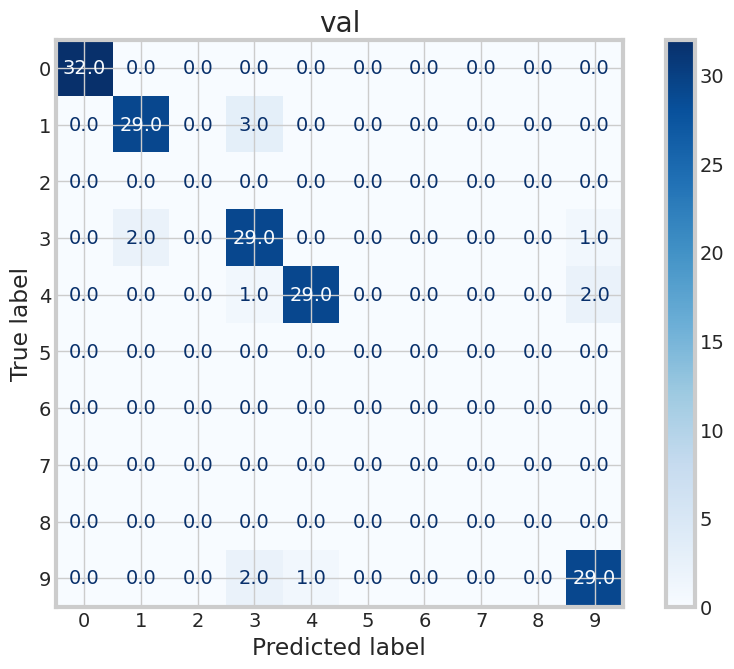

In [40]:
viz_conf(val, "val")

## Embedding Visualization

In [ ]:
test_data = receiver.ll_dataset.get_test_dataset(0, kind="one")
train_data = receiver.ll_dataset.get_train_dataset(0, kind="all")
val_data = receiver.ll_dataset.get_val_dataset(0)

X_test = torch.stack([x for x, y in test_data])
X_train = torch.stack([x for x, y in train_data])
X_val = torch.stack([x for x, y in val_data])

y_test = torch.tensor([y for x, y in test_data])
y_train = torch.tensor([y for x, y in train_data])
y_val = torch.tensor([y for x, y in val_data])

In [ ]:
# softmax
with torch.no_grad():
    y_test_hat = receiver.model.net(X_test.to(receiver.model.device))
    y_val_hat = receiver.model.net(X_val.to(receiver.model.device))

In [ ]:
y_test_pred = torch.argmax(y_test_hat, dim=1)
y_val_pred = torch.argmax(y_val_hat, dim=1)

In [ ]:
def sep_incorrect_correct(X, y, y_pred):
    # if y_test and y_pred not in the same device, move them to the same device
    if y.device != y_pred.device:
        y = y.to(y_pred.device)
    correct_idx = y_pred == y
    incorrect_idx = y_pred != y
    correct_X = torch.stack([X[i] for i in range(len(y)) if correct_idx[i]])
    correct_y_label = torch.tensor([y[i] for i in range(len(y)) if correct_idx[i]])
    incorrect_X = torch.stack([X[i] for i in range(len(y)) if incorrect_idx[i]])
    incorrect_y_label = torch.tensor([y[i] for i in range(len(y)) if incorrect_idx[i]])
    incorrect_y_pred = torch.tensor([y_pred[i] for i in range(len(y_pred)) if incorrect_idx[i]])
    return {
        "correct": {"x": correct_X, "y": correct_y_label, "idx": correct_idx},
        "incorrect": {"x": incorrect_X, "y": incorrect_y_label, "y_pred": incorrect_y_pred, "idx": incorrect_idx},
    }

In [ ]:
val_sep = sep_incorrect_correct(X_val, y_val, y_val_pred)
test_sep = sep_incorrect_correct(X_test, y_test, y_test_pred)

In [ ]:
def viz_img_error(sep, num_samples=10):
    correct_X = sep["correct"]["x"]
    correct_y_label = sep["correct"]["y"]
    incorrect_X = sep["incorrect"]["x"]
    incorrect_y_label = sep["incorrect"]["y"]
    incorrect_y_pred = sep["incorrect"]["y_pred"]

    print(f"Number of correct samples: {len(correct_X)}")
    print(f"Number of incorrect samples: {len(incorrect_X)}")
    print(f"accuracy: {len(correct_X) / (len(correct_X) + len(incorrect_X)):.3f}")
    num_samples = min(num_samples, len(correct_X), len(incorrect_X))
    some_correct_idx = random.sample(range(len(correct_X)), num_samples)
    some_incorrect_idx = random.sample(range(len(incorrect_X)), num_samples)


    # plot the images, labels, and predictions

    fig, axes = plt.subplots(2, num_samples, figsize=(30, 5))
    for i in range(num_samples):
        if len(correct_X) >= num_samples:
            axes[0, i].imshow(correct_X[some_correct_idx[i]].squeeze(), cmap="gray")
            axes[0, i].set_title(f"Label: {correct_y_label[some_correct_idx[i]]}, Pred: {correct_y_label[some_correct_idx[i]]}")
        if len(incorrect_X) >= num_samples:
            axes[1, i].imshow(incorrect_X[some_incorrect_idx[i]].squeeze(), cmap="gray")
            axes[1, i].set_title(f"Label: {incorrect_y_label[some_incorrect_idx[i]]}, Pred: {incorrect_y_pred[some_incorrect_idx[i]]}")

    plt.tight_layout()


In [ ]:
viz_img_error(test_sep)

In [ ]:
viz_img_error(val_sep)

In [ ]:
X_test_val = torch.cat([X_test, X_val])
y_test_val = torch.cat([y_test, y_val])
receiver_reducer = umap.UMAP(n_neighbors=10, random_state=42)
receiver_reducer.fit(to_features(X_test_val))

In [ ]:
def viz_embed(X, y, reducer, y_pred=None, sep=None, small_alpha_cls=None):
    # plot the reducer tsne projection with the labels labeled and colored
    fig, ax = plt.subplots(figsize=(10, 10))

    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
    centroids = []

    # scatter with labels colored by class
    for i in range(10):
        test_cls_idx = y == i
        color = colors.pop(0)
        if test_cls_idx.sum() > 0:
            X_test_embed_cls = reducer.transform(to_features(X[test_cls_idx]))

            if sep is not None:
                X_test_embed_cls_correct = X_test_embed_cls[sep["correct"]["idx"][test_cls_idx].to("cpu")]
                X_test_embed_cls_incorrect = X_test_embed_cls[sep["incorrect"]["idx"][test_cls_idx].to("cpu")]


                ax.scatter(X_test_embed_cls_correct[:, 0], X_test_embed_cls_correct[:, 1], c=color, 
                            marker="o",
                            label=f"Class {i}",
                            alpha=0.1)
                
                
                ax.scatter(X_test_embed_cls_incorrect[:, 0], X_test_embed_cls_incorrect[:, 1], c=color,
                                marker="x")
                if y_pred is not None:
                    # # annotate the incorrect ones with pred/label pair
                    for j in range(len(X_test_embed_cls_incorrect)):
                        pred = y_pred[sep["incorrect"]["idx"].to("cpu") & test_cls_idx][j]
                        ax.annotate(f"{pred}/{i}",
                                    (X_test_embed_cls_incorrect[j, 0], X_test_embed_cls_incorrect[j, 1]),
                                    color="black",
                                    alpha=0.5)
            else:
                alpha = 1.0
                s=100
                if small_alpha_cls is not None and i in small_alpha_cls:
                    alpha = 0.1
                    s = 10
                ax.scatter(
                    X_test_embed_cls[:, 0], X_test_embed_cls[:, 1], c=color,
                    label=f"Class {i}",
                    alpha=alpha,
                    s=s,
                )
            

    plt.title("2D projection")
    leg = ax.legend();
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    plt.tight_layout();

In [ ]:
viz_embed(X_test, y_test, receiver_reducer, sep=test_sep)

In [ ]:
viz_embed(X_val, y_val, receiver_reducer, y_val_pred, sep=val_sep)

In [ ]:
viz_embed(X_test_val, y_test_val, receiver_reducer)

## Data Sharing

In [ ]:
# Cheating 1: train directly on the wrongly classified points on the val set

# wrong_val_idx = val_sep["incorrect"]["idx"].to("cpu")
# wrong_val_X = X_val[wrong_val_idx]
# wrong_val_y = y_val[wrong_val_idx]

wrong_val_X = val_sep["incorrect"]["x"]
wrong_val_y = val_sep["incorrect"]["y"]

cheat1 = deepcopy(receiver)
print("buffer before:", len(cheat1.buffer))
cheat1.buffer.add_data((wrong_val_X, wrong_val_y))
print("buffer after:", len(cheat1.buffer))

cheat1.learn_from_buffer(ll_time=0, kind="all", metric="past_task_val_acc",
    val_before=False, record_name="cheat1.csv")

snapshot_conf_mat(cheat1, ll_time=RES_LL_TIME, record_name="cheat1")

In [ ]:
df = pd.read_csv(f"cheat1.csv")
df.plot(x="epoch", y=["train_acc", "val_acc", "test_acc"]);
print(f"final val acc: {df['val_acc'].iloc[-1]:.3f} best val acc: {df['val_acc'].max():.3f} @ epoch {df['epoch'][df['val_acc'].idxmax()]}")
print(f"final test acc: {df['test_acc'].iloc[-1]:.3f} best test acc: {df['test_acc'].max():.3f} @ epoch {df['epoch'][df['test_acc'].idxmax()]}")
print(f"Train accuracy at best val accuracy: {df['train_acc'][df['val_acc'].idxmax()]:.3f}")

In [ ]:
cheat1_conf = np.load(f"cheat1_train_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(cheat1_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Train Confusion Matrix");
print(per_class_acc(cheat1_conf))
print(acc(cheat1_conf));

In [ ]:
cheat1_conf = np.load(f"cheat1_test_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(cheat1_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Test Confusion Matrix");
print(per_class_acc(cheat1_conf))
print(acc(cheat1_conf));

In [ ]:
cheat1_conf = np.load(f"cheat1_val_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(cheat1_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Val Confusion Matrix");
print(per_class_acc(cheat1_conf))
print(acc(cheat1_conf));

In [ ]:
# Cheating 2: train directly on the wrongly classified points on the test set (even stronger cheat, lfgggg!)

# wrong_test_idx = test_sep["incorrect"]["idx"].to("cpu")
# wrong_test_X = X_test[wrong_test_idx]
# wrong_test_y = y_test[wrong_test_idx]

wrong_test_X = test_sep["incorrect"]["x"]
wrong_test_y = test_sep["incorrect"]["y"]

cheat2 = deepcopy(receiver)
print("buffer before:", len(cheat2.buffer))
cheat2.buffer.add_data((wrong_test_X, wrong_test_y))
print("buffer after:", len(cheat2.buffer))

cheat2.learn_from_buffer(ll_time=0, kind="all", metric="past_task_val_acc",
    val_before=False, record_name="cheat2.csv")

snapshot_conf_mat(cheat2, ll_time=RES_LL_TIME, record_name="cheat2")

In [ ]:
df = pd.read_csv(f"cheat2.csv")
df.plot(x="epoch", y=["train_acc", "val_acc", "test_acc"]);
print(f"final val acc: {df['val_acc'].iloc[-1]:.3f} best val acc: {df['val_acc'].max():.3f} @ epoch {df['epoch'][df['val_acc'].idxmax()]}")
print(f"final test acc: {df['test_acc'].iloc[-1]:.3f} best test acc: {df['test_acc'].max():.3f} @ epoch {df['epoch'][df['test_acc'].idxmax()]}")
print(f"Train accuracy at best val accuracy: {df['train_acc'][df['val_acc'].idxmax()]:.3f}")

In [ ]:
cheat2_conf = np.load(f"cheat2_train_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(cheat2_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Train Confusion Matrix");
print(per_class_acc(cheat2_conf))
print(acc(cheat2_conf));

In [ ]:
cheat2_conf = np.load(f"cheat2_test_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(cheat2_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Test Confusion Matrix");
print(per_class_acc(cheat2_conf))
print(acc(cheat2_conf));

In [ ]:
cheat2_conf = np.load(f"cheat2_val_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(cheat2_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Val Confusion Matrix");
print(per_class_acc(cheat2_conf))
print(acc(cheat2_conf));

## Active learning to get more samples

In [17]:
sender_data = sender.ll_dataset.get_train_dataset(0, kind="all")

# # NOTE: HACK: CHEAT: cheating super hard...
# sender_test_data = sender.ll_dataset.get_test_dataset(0, kind="all")
# sender_data = torch.utils.data.ConcatDataset([sender_data, sender_test_data])

X_sender = torch.stack([x for x, y in sender_data])
y_sender = torch.tensor([y for x, y in sender_data])
print(X_sender.shape)

torch.Size([320, 1, 28, 28])


### Class-performance

In [18]:
receiver.data_valuation_class_perf(X_sender, y_sender, ll_time=0)

CRITICAL:root:Buffer size: 382 cls distribution (tensor([0, 1, 3, 4, 9]), tensor([126,  64,  64,  64,  64]))
CRITICAL:root:Class 0 before 0.925 after 0.9375 len 64 contribution: 0.013513513513513466
CRITICAL:root:Buffer size: 384 cls distribution (tensor([0, 1, 2, 3, 4, 9]), tensor([64, 64, 64, 64, 64, 64]))
CRITICAL:root:Class 2 before 0.925 after 0.925 len 64 contribution: 0.0
CRITICAL:root:Buffer size: 384 cls distribution (tensor([0, 1, 3, 4, 9]), tensor([ 64,  64,  64, 128,  64]))
CRITICAL:root:Class 4 before 0.925 after 0.93125 len 64 contribution: 0.006756756756756733
CRITICAL:root:Buffer size: 384 cls distribution (tensor([0, 1, 3, 4, 5, 9]), tensor([64, 64, 64, 64, 64, 64]))
CRITICAL:root:Class 5 before 0.925 after 0.925 len 64 contribution: 0.0
CRITICAL:root:Buffer size: 384 cls distribution (tensor([0, 1, 3, 4, 9]), tensor([ 64,  64,  64,  64, 128]))
CRITICAL:root:Class 9 before 0.925 after 0.9375 len 64 contribution: 0.013513513513513466


tensor([0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135,
        0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135,
        0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135,
        0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135,
        0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135,
        0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135,
        0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135,
        0.0135, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068,
        0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068,
        0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068,
        0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068,
        0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068,
        0.0068, 0.0068, 0.0068, 0.0068, 

In [20]:
train_cls0, test_cls0, val_cls0 = load_snapshot_conf_mats("after_class_0", RES_LL_TIME)
train_cls2, test_cls2, val_cls2 = load_snapshot_conf_mats("after_class_2", RES_LL_TIME)
train_cls4, test_cls4, val_cls4 = load_snapshot_conf_mats("after_class_4", RES_LL_TIME)
train_cls5, test_cls5, val_cls5 = load_snapshot_conf_mats("after_class_5", RES_LL_TIME)
train_cls9, test_cls9, val_cls9 = load_snapshot_conf_mats("after_class_9", RES_LL_TIME)


In [21]:
# before
train_cls0_before, test_cls0_before, val_cls0_before = load_snapshot_conf_mats("before_class_0", RES_LL_TIME)
train_cls2_before, test_cls2_before, val_cls2_before = load_snapshot_conf_mats("before_class_2", RES_LL_TIME)
train_cls4_before, test_cls4_before, val_cls4_before = load_snapshot_conf_mats("before_class_4", RES_LL_TIME)
train_cls5_before, test_cls5_before, val_cls5_before = load_snapshot_conf_mats("before_class_5", RES_LL_TIME)
train_cls9_before, test_cls9_before, val_cls9_before = load_snapshot_conf_mats("before_class_9", RES_LL_TIME)

In [24]:
df1,_, _ = summarize_confs([train_cls0_before, train_cls2_before, train_cls4_before, train_cls5_before, train_cls9_before],
["0", "2", "4", "5", "9"])
df1

/tmp/ipykernel_2446859/4123088172.py:3: RuntimeWarning: invalid value encountered in divide
  return np.diag(conf_mat) / conf_mat.sum(axis=1)


,name,acc,per_class_acc_0,per_class_acc_1,per_class_acc_2,per_class_acc_3,per_class_acc_4,per_class_acc_5,per_class_acc_6,per_class_acc_7,per_class_acc_8,per_class_acc_9
0,0,0.960733,0.968254,0.984375,NaN,1.0,0.953125,NaN,NaN,NaN,NaN,0.890625
1,2,0.804688,1.000000,0.984375,0.0,1.0,0.953125,NaN,NaN,NaN,NaN,0.890625
2,4,0.950521,1.000000,0.984375,NaN,1.0,0.914062,NaN,NaN,NaN,NaN,0.890625
3,5,0.804688,1.000000,0.984375,NaN,1.0,0.953125,0.0,NaN,NaN,NaN,0.890625
4,9,0.966146,1.000000,0.984375,NaN,1.0,0.953125,NaN,NaN,NaN,NaN,0.929688


In [25]:
df1,_, _ = summarize_confs([train_cls0, train_cls2, train_cls4, train_cls5, train_cls9],
["0", "2", "4", "5", "9"])
df1

/tmp/ipykernel_2446859/4123088172.py:3: RuntimeWarning: invalid value encountered in divide
  return np.diag(conf_mat) / conf_mat.sum(axis=1)


,name,acc,per_class_acc_0,per_class_acc_1,per_class_acc_2,per_class_acc_3,per_class_acc_4,per_class_acc_5,per_class_acc_6,per_class_acc_7,per_class_acc_8,per_class_acc_9
0,0,0.989529,0.992063,1.0,NaN,1.00000,0.984375,NaN,NaN,NaN,NaN,0.968750
1,2,0.955729,1.000000,1.0,0.875,0.96875,0.953125,NaN,NaN,NaN,NaN,0.937500
2,4,0.989583,1.000000,1.0,NaN,1.00000,0.992188,NaN,NaN,NaN,NaN,0.953125
3,5,0.994792,1.000000,1.0,NaN,1.00000,0.984375,1.0,NaN,NaN,NaN,0.984375
4,9,0.992188,1.000000,1.0,NaN,1.00000,0.984375,NaN,NaN,NaN,NaN,0.984375


In [27]:
df1,_, _ = summarize_confs([test_cls0_before, test_cls2_before, test_cls4_before, test_cls5_before, test_cls9_before],
["0", "2", "4", "5", "9"])
df1

/tmp/ipykernel_2446859/4123088172.py:3: RuntimeWarning: invalid value encountered in divide
  return np.diag(conf_mat) / conf_mat.sum(axis=1)


,name,acc,per_class_acc_0,per_class_acc_1,per_class_acc_2,per_class_acc_3,per_class_acc_4,per_class_acc_5,per_class_acc_6,per_class_acc_7,per_class_acc_8,per_class_acc_9
0,0,0.940188,0.967347,0.974449,NaN,0.957426,0.892057,NaN,NaN,NaN,NaN,0.904856
1,2,0.940188,0.967347,0.974449,NaN,0.957426,0.892057,NaN,NaN,NaN,NaN,0.904856
2,4,0.940188,0.967347,0.974449,NaN,0.957426,0.892057,NaN,NaN,NaN,NaN,0.904856
3,5,0.940188,0.967347,0.974449,NaN,0.957426,0.892057,NaN,NaN,NaN,NaN,0.904856
4,9,0.940188,0.967347,0.974449,NaN,0.957426,0.892057,NaN,NaN,NaN,NaN,0.904856


In [26]:
df1,_, _ = summarize_confs([test_cls0, test_cls2, test_cls4, test_cls5, test_cls9],
["0", "2", "4", "5", "9"])
df1

/tmp/ipykernel_2446859/4123088172.py:3: RuntimeWarning: invalid value encountered in divide
  return np.diag(conf_mat) / conf_mat.sum(axis=1)


,name,acc,per_class_acc_0,per_class_acc_1,per_class_acc_2,per_class_acc_3,per_class_acc_4,per_class_acc_5,per_class_acc_6,per_class_acc_7,per_class_acc_8,per_class_acc_9
0,0,0.940774,0.988776,0.963877,NaN,0.939604,0.926680,NaN,NaN,NaN,NaN,0.883053
1,2,0.923964,0.972449,0.984141,NaN,0.872277,0.863544,NaN,NaN,NaN,NaN,0.919722
2,4,0.945661,0.966327,0.976211,NaN,0.940594,0.953157,NaN,NaN,NaN,NaN,0.888999
3,5,0.931392,0.970408,0.969163,NaN,0.919802,0.865580,NaN,NaN,NaN,NaN,0.926660
4,9,0.944683,0.969388,0.968282,NaN,0.942574,0.919552,NaN,NaN,NaN,NaN,0.920714


In [28]:
df1, _, _ = summarize_confs([val_cls0_before, val_cls2_before, val_cls4_before, val_cls5_before, val_cls9_before],
["0", "2", "4", "5", "9"])
df1

/tmp/ipykernel_2446859/4123088172.py:3: RuntimeWarning: invalid value encountered in divide
  return np.diag(conf_mat) / conf_mat.sum(axis=1)


,name,acc,per_class_acc_0,per_class_acc_1,per_class_acc_2,per_class_acc_3,per_class_acc_4,per_class_acc_5,per_class_acc_6,per_class_acc_7,per_class_acc_8,per_class_acc_9
0,0,0.925,1.0,0.90625,NaN,0.90625,0.90625,NaN,NaN,NaN,NaN,0.90625
1,2,0.925,1.0,0.90625,NaN,0.90625,0.90625,NaN,NaN,NaN,NaN,0.90625
2,4,0.925,1.0,0.90625,NaN,0.90625,0.90625,NaN,NaN,NaN,NaN,0.90625
3,5,0.925,1.0,0.90625,NaN,0.90625,0.90625,NaN,NaN,NaN,NaN,0.90625
4,9,0.925,1.0,0.90625,NaN,0.90625,0.90625,NaN,NaN,NaN,NaN,0.90625


In [34]:
df1, df2, df3 = summarize_confs([val_cls0, val_cls2, val_cls4, val_cls5, val_cls9],
["0", "2", "4", "5", "9"])
df1
df3

/tmp/ipykernel_2446859/4123088172.py:3: RuntimeWarning: invalid value encountered in divide
  return np.diag(conf_mat) / conf_mat.sum(axis=1)


,name,acc,per_class_acc_0,per_class_acc_1,per_class_acc_2,per_class_acc_3,per_class_acc_4,per_class_acc_5,per_class_acc_6,per_class_acc_7,per_class_acc_8,per_class_acc_9
0,0,0.93750,1.0,0.93750,NaN,0.90625,0.93750,NaN,NaN,NaN,NaN,0.90625
1,2,0.92500,1.0,0.90625,NaN,0.87500,0.90625,NaN,NaN,NaN,NaN,0.93750
2,4,0.93125,1.0,0.90625,NaN,0.87500,0.96875,NaN,NaN,NaN,NaN,0.90625
3,5,0.92500,1.0,0.90625,NaN,0.90625,0.90625,NaN,NaN,NaN,NaN,0.90625
4,9,0.93750,1.0,0.90625,NaN,0.90625,0.96875,NaN,NaN,NaN,NaN,0.90625


,name,predicted_cls_freq_0,predicted_cls_freq_1,predicted_cls_freq_2,predicted_cls_freq_3,predicted_cls_freq_4,predicted_cls_freq_5,predicted_cls_freq_6,predicted_cls_freq_7,predicted_cls_freq_8,predicted_cls_freq_9
0,0,0.2,0.19375,0.0000,0.20625,0.20625,0.00000,0.0,0.0,0.0,0.19375
1,2,0.2,0.19375,0.0125,0.19375,0.19375,0.00000,0.0,0.0,0.0,0.20625
2,4,0.2,0.18750,0.0000,0.21250,0.21250,0.00000,0.0,0.0,0.0,0.18750
3,5,0.2,0.18750,0.0000,0.20000,0.19375,0.00625,0.0,0.0,0.0,0.21250
4,9,0.2,0.18750,0.0000,0.21250,0.20625,0.00000,0.0,0.0,0.0,0.19375


/tmp/ipykernel_2446859/4123088172.py:3: RuntimeWarning: invalid value encountered in divide
  return np.diag(conf_mat) / conf_mat.sum(axis=1)


accuracy [1.      0.90625     nan 0.875   0.90625     nan     nan     nan     nan
 0.9375 ]
overall accuracy 0.925
predicted freq: [0.2     0.19375 0.0125  0.19375 0.19375 0.      0.      0.      0.
 0.20625]


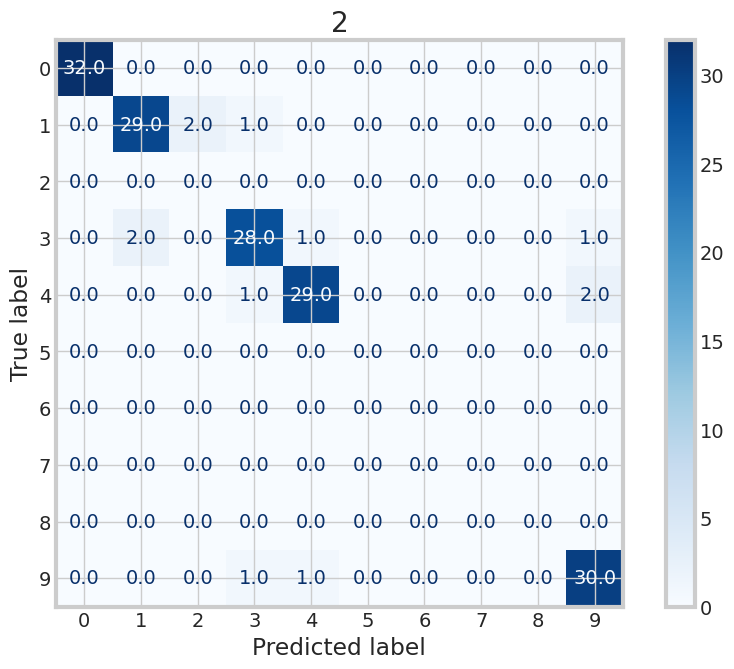

In [39]:
viz_conf(val_cls2, "2")

<AxesSubplot: xlabel='epoch'>

final val acc: 0.887 best val acc: 0.925 @ epoch 13
final test acc: 0.927 best test acc: 0.931 @ epoch 19
Train accuracy at best val accuracy: 0.972


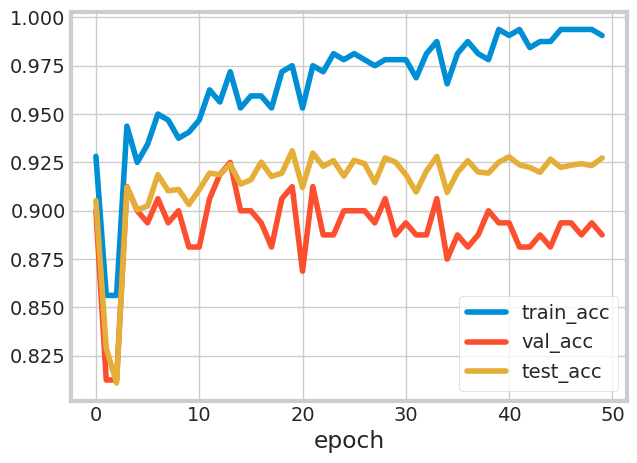

In [32]:
df = pd.read_csv(f"record_cls_eval_0_class_2.csv")
# shortened = df.iloc[15:]
shortened = df.iloc[:]
shortened.plot(x="epoch", y=["train_acc", "val_acc", "test_acc"]);
print(f"final val acc: {df['val_acc'].iloc[-1]:.3f} best val acc: {df['val_acc'].max():.3f} @ epoch {df['epoch'][df['val_acc'].idxmax()]}")
print(f"final test acc: {df['test_acc'].iloc[-1]:.3f} best test acc: {df['test_acc'].max():.3f} @ epoch {df['epoch'][df['test_acc'].idxmax()]}")
print(f"Train accuracy at best val accuracy: {df['train_acc'][df['val_acc'].idxmax()]:.3f}")

In [ ]:
df = pd.read_csv(f"record_cls_eval_0_class_0.csv")
# shortened = df.iloc[15:]
shortened = df.iloc[:]
shortened.plot(x="epoch", y=["train_acc", "val_acc", "test_acc"]);
print(f"final val acc: {df['val_acc'].iloc[-1]:.3f} best val acc: {df['val_acc'].max():.3f} @ epoch {df['epoch'][df['val_acc'].idxmax()]}")
print(f"final test acc: {df['test_acc'].iloc[-1]:.3f} best test acc: {df['test_acc'].max():.3f} @ epoch {df['epoch'][df['test_acc'].idxmax()]}")
print(f"Train accuracy at best val accuracy: {df['train_acc'][df['val_acc'].idxmax()]:.3f}")

In [ ]:
"""
Three strategies to rank samples. Scorer assigns a score
to each data point (train + val) so the receiver can request such images from the sender 

- Least confident: prioritize the samples with the lowest confidence (i.e. lowest maximum logits)
- Margin sampling: prioritize the samples with the lowest margin (i.e. difference between the two highest logits)
- Entropy: prioritize the samples with the highest entropy (i.e. highest entropy of the softmax distribution)


Higher score means more valuable to train more on.
"""
import torch.nn.functional as F

def least_confidence_scorer(X, model):
    with torch.no_grad():
        logits = model(X)
        return -torch.max(logits, dim=1).values

def margin_scorer(X, model):
    with torch.no_grad():
        logits = model(X)
        max_logits, _ = torch.max(logits, dim=1)
        second_max_logits = torch.topk(logits, k=2, dim=1).values[:, 1]
        return -(max_logits - second_max_logits)

def entropy_scorer(X, model):
    with torch.no_grad():
        logits = model(X)
        probs = F.softmax(logits, dim=1)
        return -torch.sum(probs * torch.log(probs), dim=1)


In [ ]:
# NOTE: HACK: CHEAT
X_train_val = torch.cat([X_train, X_val]).to("cuda")
# X_train_val = torch.cat([X_train, X_val, X_test]).to("cuda")
lc_scores = least_confidence_scorer(X_train_val, receiver.model.net)
ms_scores = margin_scorer(X_train_val, receiver.model.net)
ent_scores = entropy_scorer(X_train_val, receiver.model.net)

In [ ]:
# rank the samples based on various scores
lc_rank = torch.argsort(lc_scores, descending=True)
ms_rank = torch.argsort(ms_scores, descending=True)
ent_rank = torch.argsort(ent_scores, descending=True)

In [ ]:
plt.scatter(lc_scores.cpu(), ms_scores.cpu(), alpha=0.1)
plt.ylabel("Margin sampling score")
plt.xlabel("Least confidence score")
plt.title("Least confidence vs Margin sampling scores");

In [ ]:
# plot the lc_scores and ent_scores (positive correlation)

# normalize lc_scores between 0 and 1
lc_scores_normed = (lc_scores - lc_scores.min()) / (lc_scores.max() - lc_scores.min())
plt.scatter(
    lc_scores_normed.cpu(), ent_scores.cpu(), alpha=0.1
)
plt.ylabel("Entropy score")
plt.xlabel("Least confidence score")
plt.title("Least confidence vs Entropy scores");

In [ ]:
n_neighbors = 10
# rank the samples and choose top k
k = 50

In [ ]:
topk_val_wrong = val_sep["incorrect"]["x"].to("cuda")
topk_val_wrong_y = val_sep["incorrect"]["y"].to("cuda")

In [ ]:
topk_lc = X_train_val[lc_rank[:k]]
topk_ms = X_train_val[ms_rank[:k]]
topk_ent = X_train_val[ent_rank[:k]]

# plot the top k samples

fig, ax = plt.subplots(4, min(k, 10), figsize=(15, 10))
for i in range(min(k, 10)):
    ax[0, i].imshow(topk_lc[i].cpu().permute(1, 2, 0), cmap="gray")
    ax[0, i].axis("off")
    ax[1, i].imshow(topk_ms[i].cpu().permute(1, 2, 0), cmap="gray")
    ax[1, i].axis("off")
    ax[2, i].imshow(topk_ent[i].cpu().permute(1, 2, 0), cmap="gray")
    ax[2, i].axis("off")
    ax[3, i].imshow(topk_val_wrong[i].cpu().permute(1, 2, 0), cmap="gray")
    ax[3, i].axis("off")

ax[0, 0].set_title("Least confidence")
ax[1, 0].set_title("Margin sampling")
ax[2, 0].set_title("Entropy");
ax[3, 0].set_title("Wrongly validated");

In [ ]:
# (not using siamese network). Compute the similarity between images based on clustering stuff.
def image_sim(queries, database, reducer, p=2, n_neighbors=10):
    query_embed = torch.tensor(reducer.transform(to_features(queries.to("cpu"))))
    database_embed = torch.tensor(reducer.transform(to_features(database.to("cpu"))))
    dist = torch.cdist(query_embed, database_embed, p=p)
    closest_dist, closest_idx = torch.topk(dist, k=n_neighbors, dim=1, largest=False)
    return closest_dist, closest_idx

## Outlier dection

In [ ]:
X_query_sender = torch.cat([X_sender.to("cpu"), topk_val_wrong.to("cpu")])
y_query_sender = torch.cat([y_sender.to("cpu"), topk_val_wrong_y.to("cpu")])

In [ ]:
# X_query_sender = torch.cat([X_sender.to("cpu"), X_test_val.to("cpu")])
# y_query_sender = torch.cat([y_sender.to("cpu"), y_test_val.to("cpu")])

In [ ]:
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA

sender_reducer = umap.UMAP(n_neighbors=10, random_state=42)
# sender_reducer = PCA(n_components=2)
# sender_reducer = Isomap(n_jobs=-1)
# # sender_reducer = LocallyLinearEmbedding()
sender_reducer.fit(to_features(X_sender)) # NOTE: sender_reducer fit on X_sender alone doesn't work well unfortunately...
# sender_reducer.fit(to_features(X_query_sender))

In [ ]:
viz_embed(X_sender, y_sender, sender_reducer)

## Train on the wrongly validated samples (seeking from other sources as well)

In [ ]:
viz_embed(X_query_sender, y_query_sender, sender_reducer, small_alpha_cls=[0, 2, 4, 5, 9])

In [ ]:
sim_dist_val, sim_idx_val = image_sim(topk_val_wrong, X_sender, sender_reducer, n_neighbors=n_neighbors)

In [ ]:
topk_val_wrong_y

In [ ]:
# plot the query images along with their neighbors according to this metrics
# each row start with the query and following by the neighbors

fig, ax = plt.subplots(min(k, 10), min(n_neighbors + 1, 10 + 1), figsize=(40, 20))

for i in range(min(k, 10)):
    ax[i, 0].imshow(topk_val_wrong[i].cpu().permute(1, 2, 0), cmap="gray")
    ax[i, 0].axis("off")
    for j in range(min(n_neighbors, 10)):
        ax[i, j + 1].imshow(
            X_sender[sim_idx_val[i, j]].cpu().permute(1, 2, 0), cmap="gray")
        # labels it with the distance
        # ax[i, j+1].set_title(f"{sim_dist_val[i, j]:.2f}")
        
        ax[i, j + 1].axis("off")


In [ ]:
X_add_val = X_sender[sim_idx_val.flatten()]
y_add_val = y_sender[sim_idx_val.flatten()]

In [ ]:
X_add_val.shape

In [ ]:
# try to train on this data
val_learner = deepcopy(receiver)
print("buffer before", len(val_learner.buffer))
val_learner.buffer.add_data((X_add_val, y_add_val))
print("buffer after", len(val_learner.buffer))

val_learner.learn_from_buffer(ll_time=0, kind="all", metric="past_task_val_acc",
    val_before=False, record_name="val_learner.csv")

# lc_learner.learn_from_buffer(ll_time=0, kind="all", metric="past_task_test_acc",
#     val_before=False, record_name="lc_learner.csv")

snapshot_conf_mat(val_learner, ll_time=RES_LL_TIME, record_name="val_learner")

In [ ]:
df = pd.read_csv(f"val_learner.csv")
df.plot(x="epoch", y=["train_acc", "val_acc", "test_acc"]);
print(f"final val acc: {df['val_acc'].iloc[-1]:.3f} best val acc: {df['val_acc'].max():.3f} @ epoch {df['epoch'][df['val_acc'].idxmax()]}")
print(f"final test acc: {df['test_acc'].iloc[-1]:.3f} best test acc: {df['test_acc'].max():.3f} @ epoch {df['epoch'][df['test_acc'].idxmax()]}")
print(f"Train accuracy at best val accuracy: {df['train_acc'][df['val_acc'].idxmax()]:.3f}")

In [ ]:
val_conf = np.load(f"val_learner_train_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(val_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Train Confusion Matrix");
print(per_class_acc(val_conf))
print(acc(val_conf));

In [ ]:
val_conf = np.load(f"val_learner_test_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(val_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Test Confusion Matrix");
print(per_class_acc(val_conf))
print(acc(val_conf));
print(predicted_cls_freq(val_conf))

In [ ]:
val_conf = np.load(f"val_learner_val_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(val_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Val Confusion Matrix");
print(per_class_acc(val_conf))
print(acc(val_conf));
print(predicted_cls_freq(val_conf))

## Least Confidence

In [ ]:
sim_dist_lc, sim_idx_lc = image_sim(topk_lc, X_sender, reducer, n_neighbors=n_neighbors)

In [ ]:
# plot the query images along with their neighbors according to this metrics
# each row start with the query and following by the neighbors

fig, ax = plt.subplots(min(k, 10), min(n_neighbors + 1, 10 + 1), figsize=(15, 5))

for i in range(min(k, 10)):
    ax[i, 0].imshow(topk_lc[i].cpu().permute(1, 2, 0), cmap="gray")
    ax[i, 0].axis("off")
    for j in range(min(n_neighbors, 10)):
        ax[i, j + 1].imshow(
            X_sender[sim_idx_lc[i, j]].cpu().permute(1, 2, 0), cmap="gray")
        ax[i, j + 1].axis("off")


In [ ]:
X_add_lc = X_sender[sim_idx_lc.flatten()]
y_add_lc = y_sender[sim_idx_lc.flatten()]

In [ ]:
X_add_lc.shape

In [ ]:
# try to train on this data
lc_learner = deepcopy(receiver)
print("buffer before", len(lc_learner.buffer))
lc_learner.buffer.add_data((X_add_lc, y_add_lc))
print("buffer after", len(lc_learner.buffer))

lc_learner.learn_from_buffer(ll_time=0, kind="all", metric="past_task_val_acc",
    val_before=False, record_name="lc_learner.csv")

# lc_learner.learn_from_buffer(ll_time=0, kind="all", metric="past_task_test_acc",
#     val_before=False, record_name="lc_learner.csv")

snapshot_conf_mat(lc_learner, ll_time=RES_LL_TIME, record_name="lc_learner")

In [ ]:
df = pd.read_csv(f"lc_learner.csv")
df.plot(x="epoch", y=["train_acc", "val_acc", "test_acc"]);
print(f"final val acc: {df['val_acc'].iloc[-1]:.3f} best val acc: {df['val_acc'].max():.3f} @ epoch {df['epoch'][df['val_acc'].idxmax()]}")
print(f"final test acc: {df['test_acc'].iloc[-1]:.3f} best test acc: {df['test_acc'].max():.3f} @ epoch {df['epoch'][df['test_acc'].idxmax()]}")
print(f"Train accuracy at best val accuracy: {df['train_acc'][df['val_acc'].idxmax()]:.3f}")

In [ ]:
lc_conf = np.load(f"lc_learner_train_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(lc_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Train Confusion Matrix");
print(per_class_acc(lc_conf))
print(acc(lc_conf));

In [ ]:
lc_conf = np.load(f"lc_learner_test_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(lc_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Test Confusion Matrix");
print(per_class_acc(lc_conf))
print(acc(lc_conf));

In [ ]:
lc_conf = np.load(f"lc_learner_val_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(lc_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Val Confusion Matrix");
print(per_class_acc(lc_conf))
print(acc(lc_conf));

## Margin

In [ ]:
sim_dist_ms, sim_idx_ms = image_sim(topk_ms, X_sender, reducer, n_neighbors=n_neighbors)

In [ ]:
# plot the query images along with their neighbors according to this metrics
# each row start with the query and following by the neighbors

fig, ax = plt.subplots(min(k, 10), min(n_neighbors + 1, 10 + 1), figsize=(15, 5))

for i in range(min(k, 10)):
    ax[i, 0].imshow(topk_ms[i].cpu().permute(1, 2, 0), cmap="gray")
    ax[i, 0].axis("off")
    for j in range(min(n_neighbors, 10)):
        ax[i, j + 1].imshow(
            X_sender[sim_idx_ms[i, j]].cpu().permute(1, 2, 0), cmap="gray")
        ax[i, j + 1].axis("off")


In [ ]:
X_add_ms = X_sender[sim_idx_lc.flatten()]
y_add_ms = y_sender[sim_idx_lc.flatten()]

In [ ]:
X_add_ms.shape

In [ ]:
# try to train on this data
ms_learner = deepcopy(receiver)
print("buffer before", len(ms_learner.buffer))
ms_learner.buffer.add_data((X_add_ms, y_add_ms))
print("buffer after", len(ms_learner.buffer))

ms_learner.learn_from_buffer(ll_time=0, kind="all", metric="past_task_val_acc",
    val_before=False, record_name="ms_learner.csv")

# ms_learner.learn_from_buffer(ll_time=0, kind="all", metric="past_task_test_acc",
#     val_before=False, record_name="ms_learner.csv")

snapshot_conf_mat(ms_learner, ll_time=RES_LL_TIME, record_name="ms_learner")

In [ ]:
df = pd.read_csv(f"ms_learner.csv")
df.plot(x="epoch", y=["train_acc", "val_acc", "test_acc"]);
print(f"final val acc: {df['val_acc'].iloc[-1]:.3f} best val acc: {df['val_acc'].max():.3f} @ epoch {df['epoch'][df['val_acc'].idxmax()]}")
print(f"final test acc: {df['test_acc'].iloc[-1]:.3f} best test acc: {df['test_acc'].max():.3f} @ epoch {df['epoch'][df['test_acc'].idxmax()]}")
print(f"Train accuracy at best val accuracy: {df['train_acc'][df['val_acc'].idxmax()]:.3f}")

In [ ]:
ms_conf = np.load(f"ms_learner_train_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(ms_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Train Confusion Matrix");
print(per_class_acc(ms_conf))
print(acc(ms_conf));

In [ ]:
ms_conf = np.load(f"ms_learner_test_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(ms_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Test Confusion Matrix");
print(per_class_acc(ms_conf))
print(acc(ms_conf));

In [ ]:
ms_conf = np.load(f"ms_learner_val_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(ms_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Val Confusion Matrix");
print(per_class_acc(ms_conf))
print(acc(ms_conf));

# Entropy

In [ ]:
sim_dist_ent, sim_idx_ent = image_sim(topk_ent, X_sender, reducer, n_neighbors=n_neighbors)

In [ ]:
# plot the query images along with their neighbors according to this metrics
# each row start with the query and following by the neighbors

fig, ax = plt.subplots(min(k, 10), min(n_neighbors + 1, 10 + 1), figsize=(15, 5))

for i in range(min(k, 10)):
    ax[i, 0].imshow(topk_ent[i].cpu().permute(1, 2, 0), cmap="gray")
    ax[i, 0].axis("off")
    for j in range(min(n_neighbors, 10)):
        ax[i, j + 1].imshow(
            X_sender[sim_idx_ent[i, j]].cpu().permute(1, 2, 0), cmap="gray")
        ax[i, j + 1].axis("off")


In [ ]:
X_add_ent = X_sender[sim_idx_ent.flatten()]
y_add_ent = y_sender[sim_idx_ent.flatten()]

In [ ]:
X_add_ent.shape

In [ ]:
# try to train on this data
ent_learner = deepcopy(receiver)
print("buffer before", len(ent_learner.buffer))
ent_learner.buffer.add_data((X_add_ms, y_add_ms))
print("buffer after", len(ent_learner.buffer))

ent_learner.learn_from_buffer(ll_time=0, kind="all", metric="past_task_val_acc",
    val_before=False, record_name="ent_learner.csv")

# ent_learner.learn_from_buffer(ll_time=0, kind="all", metric="past_task_test_acc",
#     val_before=False, record_name="ent_learner.csv")

snapshot_conf_mat(ent_learner, ll_time=RES_LL_TIME, record_name="ent_learner")

In [ ]:
df = pd.read_csv(f"ent_learner.csv")
df.plot(x="epoch", y=["train_acc", "val_acc", "test_acc"]);
print(f"final val acc: {df['val_acc'].iloc[-1]:.3f} best val acc: {df['val_acc'].max():.3f} @ epoch {df['epoch'][df['val_acc'].idxmax()]}")
print(f"final test acc: {df['test_acc'].iloc[-1]:.3f} best test acc: {df['test_acc'].max():.3f} @ epoch {df['epoch'][df['test_acc'].idxmax()]}")
print(f"Train accuracy at best val accuracy: {df['train_acc'][df['val_acc'].idxmax()]:.3f}")

In [ ]:
ent_conf = np.load(f"ent_learner_train_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(ent_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Train Confusion Matrix");
print(per_class_acc(ent_conf))
print(acc(ent_conf));

In [ ]:
ent_conf = np.load(f"ent_learner_test_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(ent_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Test Confusion Matrix");
print(per_class_acc(ent_conf))
print(acc(ent_conf));

In [ ]:
ent_conf = np.load(f"ent_learner_val_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(ent_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Val Confusion Matrix");
print(per_class_acc(ent_conf))
print(acc(ent_conf));

## Uninformative (Randomy routing)

In [ ]:
sim_idx_rand = torch.randint(0, len(X_sender), (k, n_neighbors))

In [ ]:
X_add_rand = X_sender[sim_idx_rand.flatten()]
y_add_rand = y_sender[sim_idx_rand.flatten()]

In [ ]:
X_add_rand.shape

In [ ]:
# try to train on this data
rand_learner = deepcopy(receiver)
print("buffer before", len(rand_learner.buffer))
rand_learner.buffer.add_data((X_add_rand, y_add_rand))
print("buffer after", len(rand_learner.buffer))

rand_learner.learn_from_buffer(ll_time=0, kind="all", metric="past_task_val_acc",
    val_before=False, record_name="rand_learner.csv")

# rand_learner.learn_from_buffer(ll_time=0, kind="all", metric="past_task_test_acc",
#     val_before=False, record_name="rand_learner.csv")

snapshot_conf_mat(rand_learner, ll_time=RES_LL_TIME, record_name="rand_learner")

In [ ]:
df = pd.read_csv(f"rand_learner.csv")
df.plot(x="epoch", y=["train_acc", "val_acc", "test_acc"]);
print(f"final val acc: {df['val_acc'].iloc[-1]:.3f} best val acc: {df['val_acc'].max():.3f} @ epoch {df['epoch'][df['val_acc'].idxmax()]}")
print(f"final test acc: {df['test_acc'].iloc[-1]:.3f} best test acc: {df['test_acc'].max():.3f} @ epoch {df['epoch'][df['test_acc'].idxmax()]}")
print(f"Train accuracy at best val accuracy: {df['train_acc'][df['val_acc'].idxmax()]:.3f}")

In [ ]:
rand_conf = np.load(f"rand_learner_train_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(rand_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Train Confusion Matrix");
print(per_class_acc(rand_conf))
print(acc(rand_conf));

In [ ]:
rand_conf = np.load(f"rand_learner_test_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(rand_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Test Confusion Matrix");
print(per_class_acc(rand_conf))
print(acc(rand_conf));

In [ ]:
rand_conf = np.load(f"rand_learner_val_conf_mat_{RES_LL_TIME}.npy")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(rand_conf).plot(cmap="Blues", values_format="", ax=ax);
plt.title("Val Confusion Matrix");
print(per_class_acc(rand_conf))
print(acc(rand_conf));